In [1]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from PIL import Image
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = "Downloads/Data/Dataset"   # path to your dataset


In [3]:
# Load training dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=42
)

# Load validation dataset (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Split validation into val + test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds  = val_ds.skip(val_batches // 2)

# Normalize
normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization(x), y))

print("Train:", sum(1 for _ in train_ds.unbatch()))
print("Val:", sum(1 for _ in val_ds.unbatch()))
print("Test:", sum(1 for _ in test_ds.unbatch()))


Found 3203 files belonging to 2 classes.
Using 2563 files for training.
Found 3203 files belonging to 2 classes.
Using 640 files for validation.
Train: 2563
Val: 320
Test: 320


In [4]:
# Load pretrained ResNet50V2
resnet = ResNet50V2(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Function to extract features
def extract_resnet_features(dataset):
    features, labels = [], []
    for batch, lab in dataset:
        feat = resnet(batch, training=False)
        features.append(feat.numpy())
        labels.append(lab.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features
X_v_train, y_train = extract_resnet_features(train_ds)
X_v_val, y_val     = extract_resnet_features(val_ds)
X_v_test, y_test   = extract_resnet_features(test_ds)

print("ResNet features shape:", X_v_train.shape)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step 
ResNet features shape: (2563, 2048)


In [5]:
def extract_pca_features_from_ds(dataset, pca=None, fit=False, pca_comp=100):
    X, y = [], []
    for batch, labels in dataset:
        for i in range(batch.shape[0]):
            img = tf.image.rgb_to_grayscale(batch[i]).numpy().squeeze()
            img = Image.fromarray((img*255).astype(np.uint8)).resize((IMG_SIZE, IMG_SIZE))
            arr = np.asarray(img, dtype=np.float32).ravel()
            X.append(arr)
        y.extend(labels.numpy())
    X = np.array(X)
    y = np.array(y)

    if fit:
        pca = PCA(n_components=pca_comp, whiten=True, random_state=42)
        X_pca = pca.fit_transform(X)
        return X_pca, y, pca
    else:
        X_pca = pca.transform(X)
        return X_pca, y

# Train PCA
X_f_train, y_train_f, pca = extract_pca_features_from_ds(train_ds, fit=True, pca_comp=100)
X_f_val, y_val_f   = extract_pca_features_from_ds(val_ds, pca, fit=False)
X_f_test, y_test_f = extract_pca_features_from_ds(test_ds, pca, fit=False)


In [6]:
# Combine ResNet features + PCA features
X_train = np.hstack([X_v_train, X_f_train])
X_val   = np.hstack([X_v_val, X_f_val])
X_test  = np.hstack([X_v_test, X_f_test])

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print("Final Train features:", X_train.shape)


Final Train features: (2563, 2148)


In [7]:
model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


C:\Users\sssss\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9762 - loss: 0.0787 - val_accuracy: 1.0000 - val_loss: 7.0363e-04
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 7.2267e-04 - val_accuracy: 1.0000 - val_loss: 3.7774e-04
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 2.1519e-04 - val_accuracy: 1.0000 - val_loss: 3.4816e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 2.5389e-04 - val_accuracy: 1.0000 - val_loss: 2.8255e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 1.0371e-04 - val_accuracy: 1.0000 - val_loss: 3.5464e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 1.9141e-04 - val_accuracy: 1.0000 - val_loss: 3.0566e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 4.4028e-05 - val_accuracy: 1.0000 - val_loss: 2.1721e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accura

In [17]:
from sklearn.metrics import f1_score

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# Print as percentages
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test F1-score: {f1_score(y_test, y_pred)*100:.2f}%")


Test Accuracy: 100.00%
Test F1-score: 100.00%


In [18]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, resnet, pca, scaler, model):
    # 1. Load and preprocess image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # shape (1,224,224,3)

    # 2. ResNet features
    resnet_feat = resnet.predict(img_array, verbose=0)

    # 3. PCA features (grayscale flatten)
    gray_img = tf.image.rgb_to_grayscale(img_array[0]).numpy().squeeze()
    gray_img = Image.fromarray((gray_img*255).astype(np.uint8)).resize((IMG_SIZE, IMG_SIZE))
    arr = np.asarray(gray_img, dtype=np.float32).ravel().reshape(1, -1)
    pca_feat = pca.transform(arr)

    # 4. Concatenate ResNet + PCA
    final_feat = np.hstack([resnet_feat, pca_feat])
    final_feat = scaler.transform(final_feat)

    # 5. Predict with trained DNN
    pred = model.predict(final_feat, verbose=0)
    class_idx = np.argmax(pred, axis=1)[0]
    confidence = pred[0][class_idx]

    classes = ["Real", "AI"]
    return classes[class_idx], confidence

# 🔹 Example usage
label, confidence = predict_image("WhatsApp Image 2025-09-19 at 5.08.18 PM (1).jpeg", resnet, pca, scaler, model)
print(f"Prediction: {label} (confidence: {confidence:.2f})")


Prediction: AI (confidence: 1.00)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


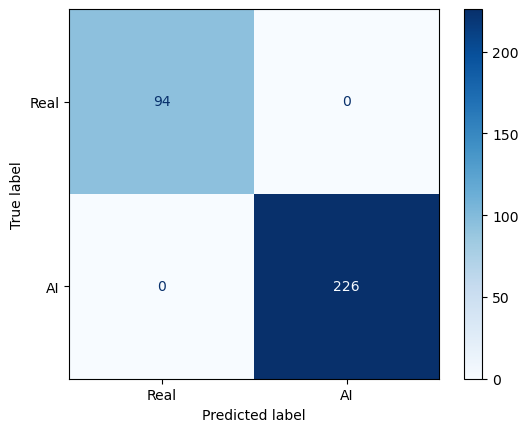

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "AI"])
disp.plot(cmap="Blues")
